# Long Short-Term Memory (LSTM)

In [1]:
import torch 
from torch import nn
from d2l import torch as d2l

The term __long short-term memory__ comes from the following intuition: Simple recurrent neural networks have _long-term memory_ in the form of weights. The weights change slowly during training, enconding general knowledge about the data. They also have _short-term memory_ in the form of ephemeral activations, which pass from each node to successive nodes. 

LSTMs resemble standard recurrent neural networks but here each ordinary recurrent node is replaced by a _memory cell_. Each memory cell contains an _internal state_, i.e., a node with a self-connected recurrent edge of fixed weight 1, ensuring that the gradient can pass across many time steps without vanishing or exploding.

The LSTM model introduces an intermediate type of storage via the memory cell. A memory cell is a composite unit, built from simpler nodes in a specific connectivity pattern, with the novel inclusion of multiplicative nodes.

## Gated Memory Cell

Each memory cell is equipped with an internal state and a number of multiplicative gates that determine whether: 

1) a given input should impact the internal state (the input gate), 
2) the internal state should be flushed to 0 (the forget gate), and
3) the internal state of a given neuron should be allowed to impact the cell's output (the output gate).

### a) Gated Hidden State

__The key distinction between vanilla RNNs and LSTMs is that the latter support gating of the hidden state.__ This means that we have dedicated mechanisms for when a hidden state should be _updated_ and also when it should be _reset_. These mechanisms are learned and they address the concerns listed above. For instance, if the first token is of great importance we will learn not to update the hidden after the first observation. Likewise, we will learn to skip irrelevant temporary observations. Last, we will learn to reset the latent state whenever needed.

### b) Input Gate, Forget Gate, and Output Gate

The data feeding into the LSTM gates are __the input at the current time step__ and __the hidden state of the previous time step__. 

Intuitively, the _input gate_ determines how much of the input node's value should be added to the current memory cell internal state. The _forget gate_ determines whether to keep the current value of the memory or flush it. And the _output gate_ determines whether the memory cell should influence the output at the current time step.

## Implementation from scratch

We initialize weights following a Gaussian distribution with 0.01 standard deviation, and we set the biases to 0.

In [3]:
class LSTMScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        self.W_xi, self.W_hi, self.b_i = triple()  # Input gate
        self.W_xf, self.W_hf, self.b_f = triple()  # Forget gate
        self.W_xo, self.W_ho, self.b_o = triple()  # Output gate
        self.W_xc, self.W_hc, self.b_c = triple()  # Input node

__Defining the forward method__:

In [4]:
@d2l.add_to_class(LSTMScratch)
def forward(self, inputs, H_C=None):
    if H_C is None:
        # Initial state with shape: (batch_size, num_hiddens)
        H = torch.zeros((inputs.shape[1], self.num_hiddens),
                      device=inputs.device)
        C = torch.zeros((inputs.shape[1], self.num_hiddens),
                      device=inputs.device)
    else:
        H, C = H_C
    outputs = []
    for X in inputs:
        I = torch.sigmoid(torch.matmul(X, self.W_xi) +
                        torch.matmul(H, self.W_hi) + self.b_i)
        F = torch.sigmoid(torch.matmul(X, self.W_xf) +
                        torch.matmul(H, self.W_hf) + self.b_f)
        O = torch.sigmoid(torch.matmul(X, self.W_xo) +
                        torch.matmul(H, self.W_ho) + self.b_o)
        C_tilde = torch.tanh(torch.matmul(X, self.W_xc) +
                           torch.matmul(H, self.W_hc) + self.b_c)
        C = F * C + I * C_tilde
        H = O * torch.tanh(C)
        outputs.append(H)
    return outputs, (H, C)

## Training and Prediction

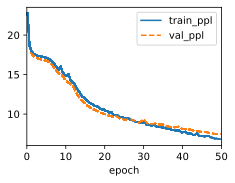

In [5]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
lstm = LSTMScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(lstm, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

## Concise Implementation

Using high-level APIs, we can directly instantiate an LSTM model. This encapsulates all the configuration details that we made explicit above. The code is significantly faster as it uses compiled operators rather than Python for many details that we spelled out before.

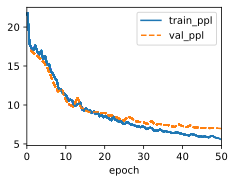

In [6]:
class LSTM(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.LSTM(num_inputs, num_hiddens)

    def forward(self, inputs, H_C=None):
        return self.rnn(inputs, H_C)

lstm = LSTM(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(lstm, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)

### Prediction:

In [7]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has it the time travel '

## Miscelaneous: 

__Implement the following LSTM variants:__


* Multiple Layers
* Residual Connections
* Different types of regularization

However, training LSTMs and other sequence models (such as GRUs) are quite costly due to the long range dependency of the sequence. That is one of the reasons they have been replaced by _transformers_.